In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from pytorch_lightning.callbacks import Callback


import torchvision
import matplotlib.pyplot as plt
import numpy as np


BATCH_SIZE = 500

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)]
)

dataset = MNIST('', train=True, download=True, transform=transform)
mnist_test = MNIST('', train=False, download=True, transform=transform)
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)

C:\Users\TecGun\Anaconda3\envs\AI\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [43]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.l1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), # batch 16 28 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2), # batch 32 14 14
            nn.Conv2d(32, 64, 3, padding=1), # batch 64 14 14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2) # batch 64 7 7
        )

        self.postproc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 16 * 7 * 7),
            nn.ReLU(),
            nn.Linear(16 * 7 * 7, 20),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.l1(x)

        out = self.postproc(out)

        out = F.gumbel_softmax(out, tau=0.4, hard=True)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), # batch 32 14 14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 8, 3, 1, 1), # batch 16 14 14
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 1, 3, 2, 1, 1), # batch 1 28 28
            nn.ReLU(),
            nn.BatchNorm2d(1),
        )

        self.preproc = nn.Sequential(
            nn.Linear(20, 16 * 7 * 7),
            nn.ReLU(),
            nn.Linear(16 * 7 * 7, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7))
        )

    def forward(self, x):
        out = self.preproc(x)
        out = self.l1(out)
        return out

class Classifier(pl.LightningModule):
    def __init__(self):
        super(Classifier, self).__init__()

        self.l1 = nn.Sequential(
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        out = self.l1(x)
        return out


class AutoEncoder(pl.LightningModule):
    def __init__(self, enc, dec, cl):
        super(AutoEncoder, self).__init__()

        self.encoder = enc
        self.decoder = dec
        self.classifier = cl

        self.lamb = 1
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.enc(x)

    def enc(self, x):
        return self.encoder(x)

    def dec(self, x):
        return self.decoder(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        z = self.encoder(x)
        x_hat = self.decoder(z)

        y_hat = self.classifier(z)

        loss_1 = F.mse_loss(x_hat, x)
        loss_2 = self.criterion(y_hat, y)

        loss = loss_1 + self.lamb * loss_2
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        z = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.classifier(z)

        loss_1 = F.mse_loss(x_hat, x)
        loss_2 = self.criterion(y_hat, y)

        loss = loss_1 + self.lamb * loss_2
        self.log('valid_loss', loss, on_step=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch

        z = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.classifier(z)

        loss_1 = F.mse_loss(x_hat, x)
        loss_2 = self.criterion(y_hat, y)

        loss = loss_1 + self.lamb * loss_2
        self.log('test_loss', loss, on_step=True, prog_bar=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch

        z = self.encoder(x)
        return self.decoder(z)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-03)
        # optimizer = torch.optim.SGD(self.parameters(), lr=1e-03, momentum=0.9)
        return optimizer


In [44]:
class Visualize(Callback):
    output = []
    test_input = torch.tensor(torch.eye(20), dtype=torch.float).cuda()

    def on_validation_epoch_end(self, trainer: 'pl.Trainer', pl_module: 'pl.LightningModule') -> None:
        if isinstance(pl_module, AutoEncoder):
            Visualize.output.append(pl_module.dec(Visualize.test_input))

enc = Encoder()
dec = Decoder()
cl = Classifier()
net = AutoEncoder(enc, dec, cl)

trainer = pl.Trainer(gpus=1, max_epochs=20, checkpoint_callback=False, logger=False, callbacks=[Visualize()])
trainer.fit(net, train_loader, val_loader)

C:\Users\TecGun\Anaconda3\envs\AI\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | encoder    | Encoder          | 2.5 M 
1 | decoder    | Decoder          | 2.5 M 
2 | classifier | Classifier       | 630   
3 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.976    Total estimated model params size (MB)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


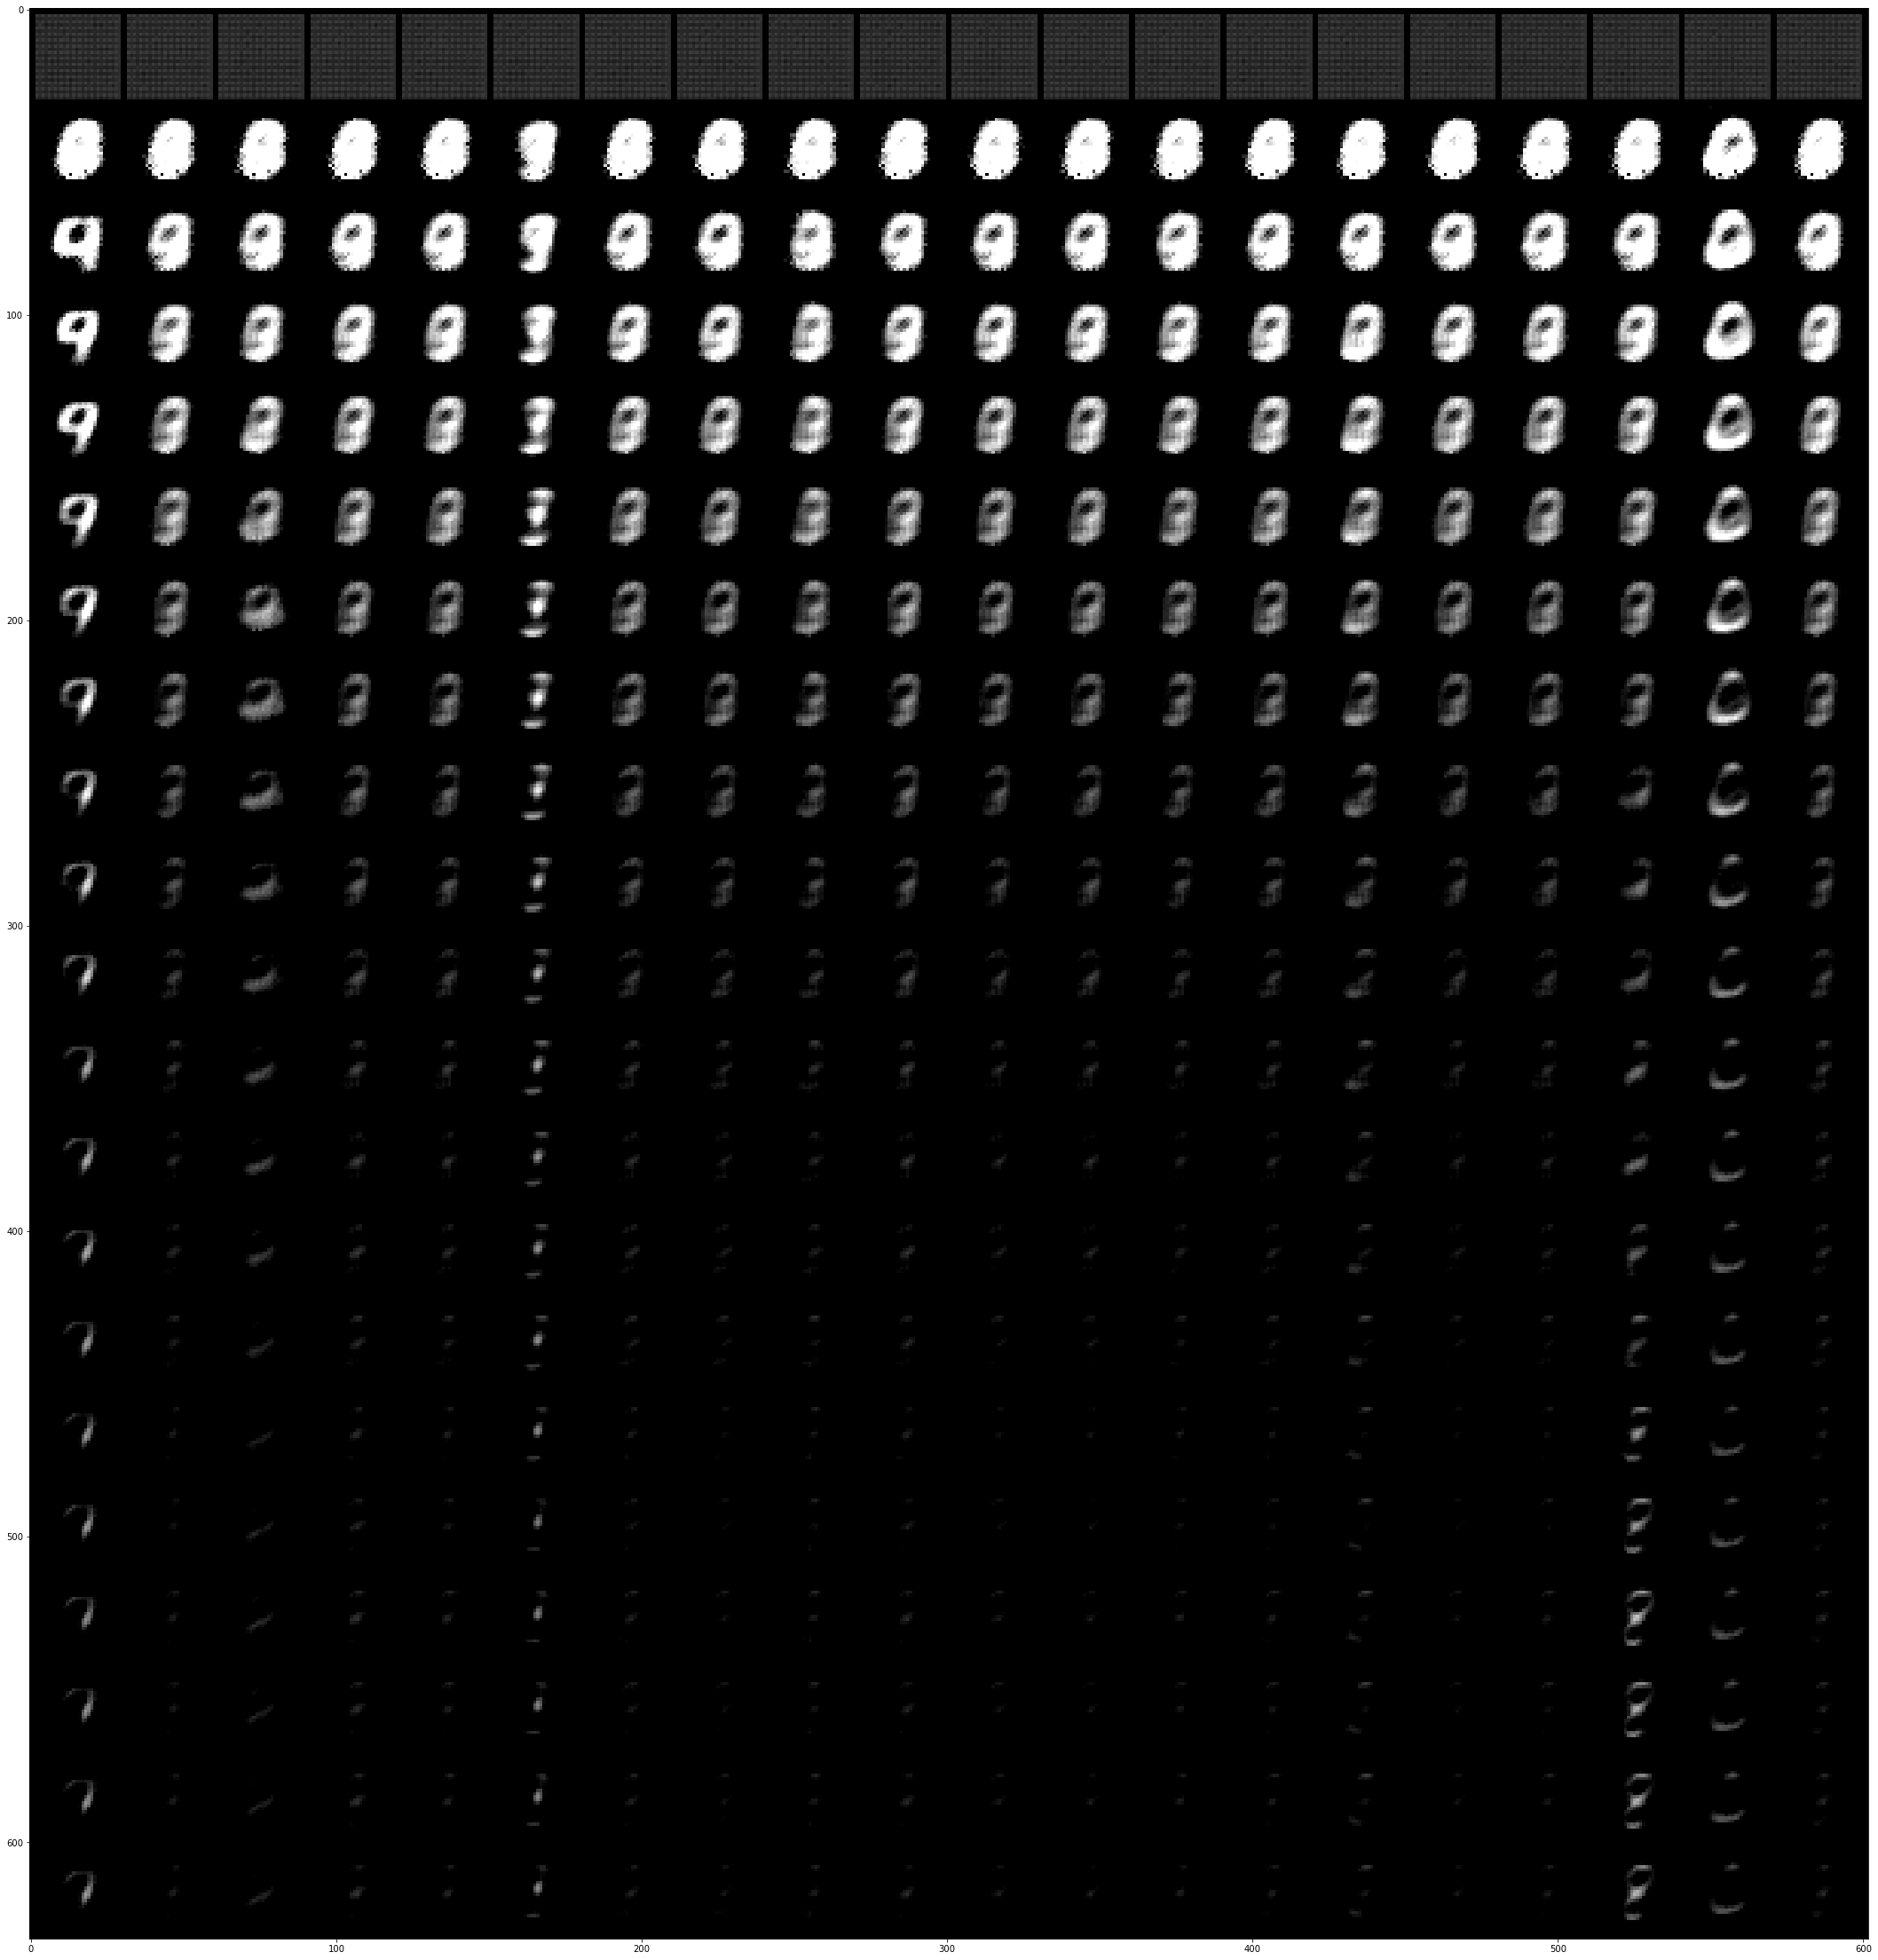

In [45]:
# grid = torchvision.utils.make_grid(net.dec(torch.eye(100)), nrow=10)
grid = torchvision.utils.make_grid(torch.cat(Visualize.output), nrow=20)
grid = grid.cpu()
plt.figure(figsize=(40, 40))
plt.imshow(grid.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


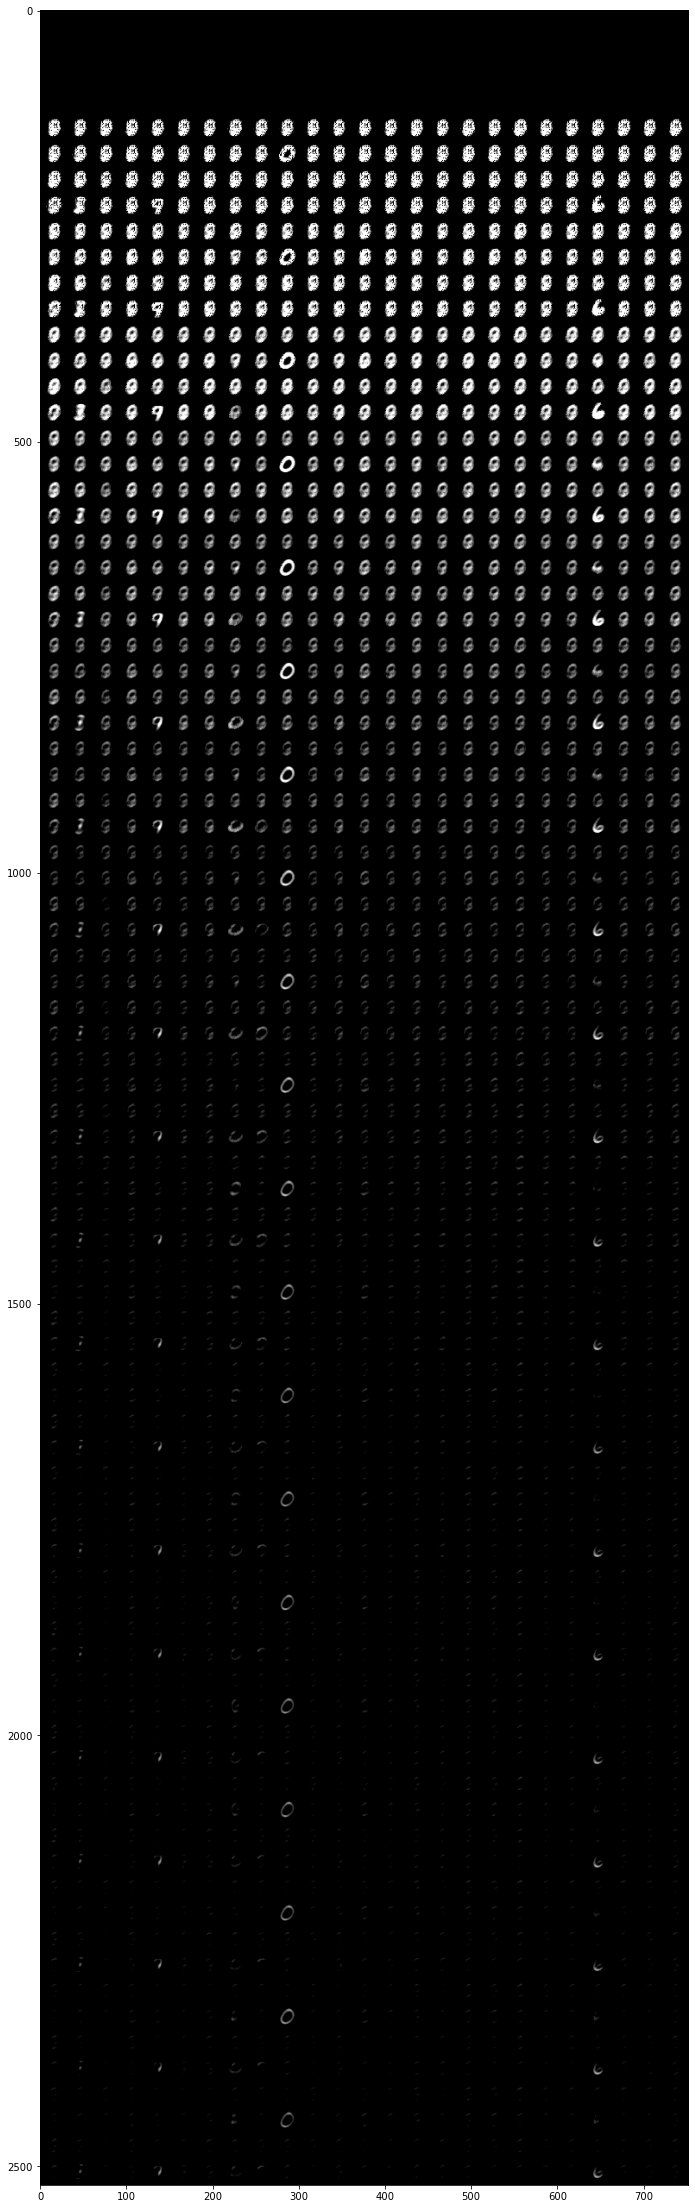

In [32]:
plt.figure(figsize=(40, 40))
plt.imshow(grid.permute(1,2,0))

In [10]:
dat = next(iter(val_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


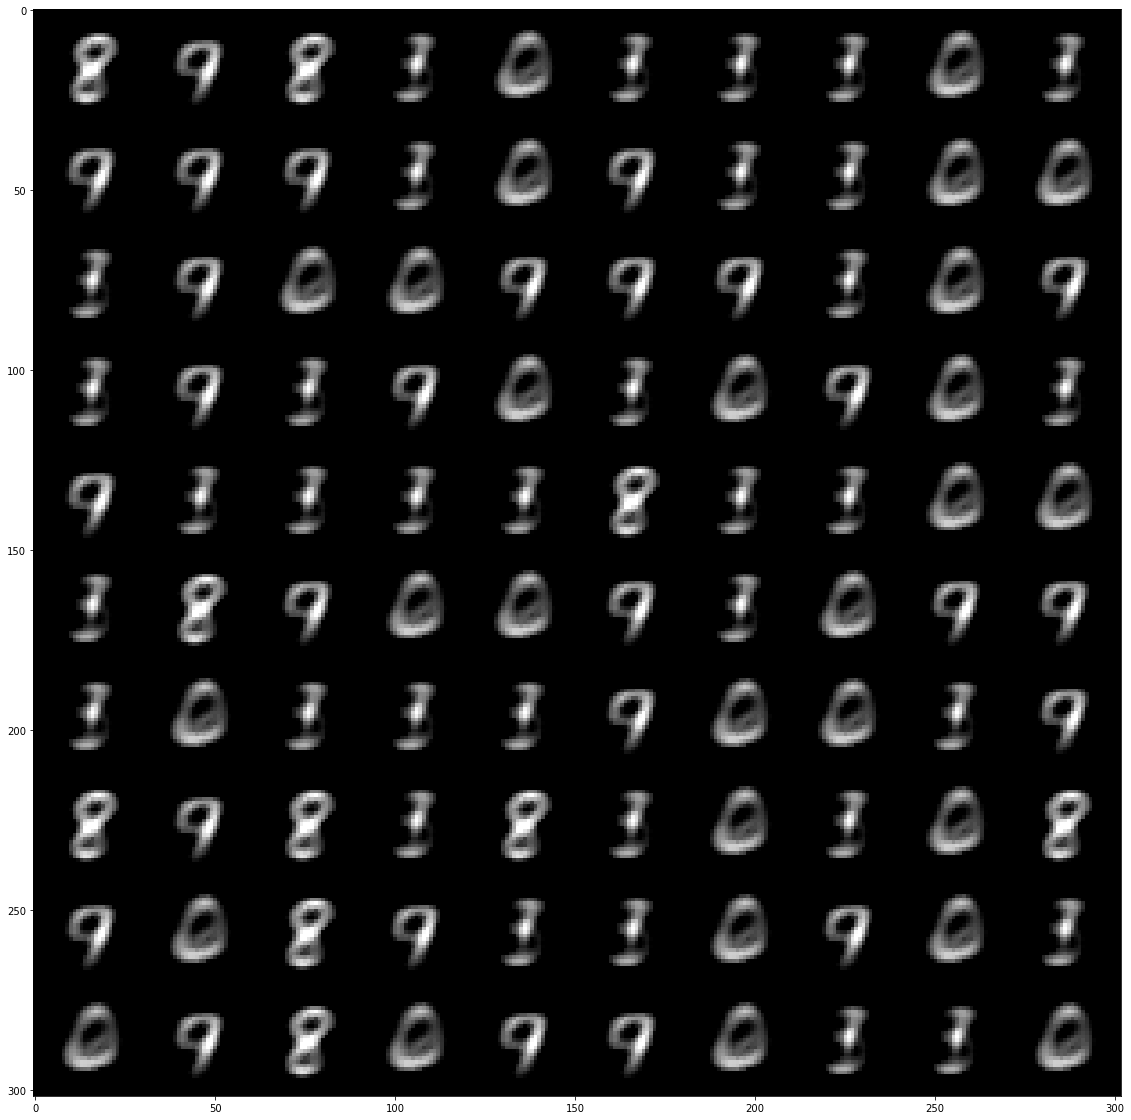

In [46]:
g = torchvision.utils.make_grid(net.dec(net.enc(dat[0]))[:100]+0.5, nrow=10).cpu()
plt.figure(figsize=(20, 20))
plt.imshow(g.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


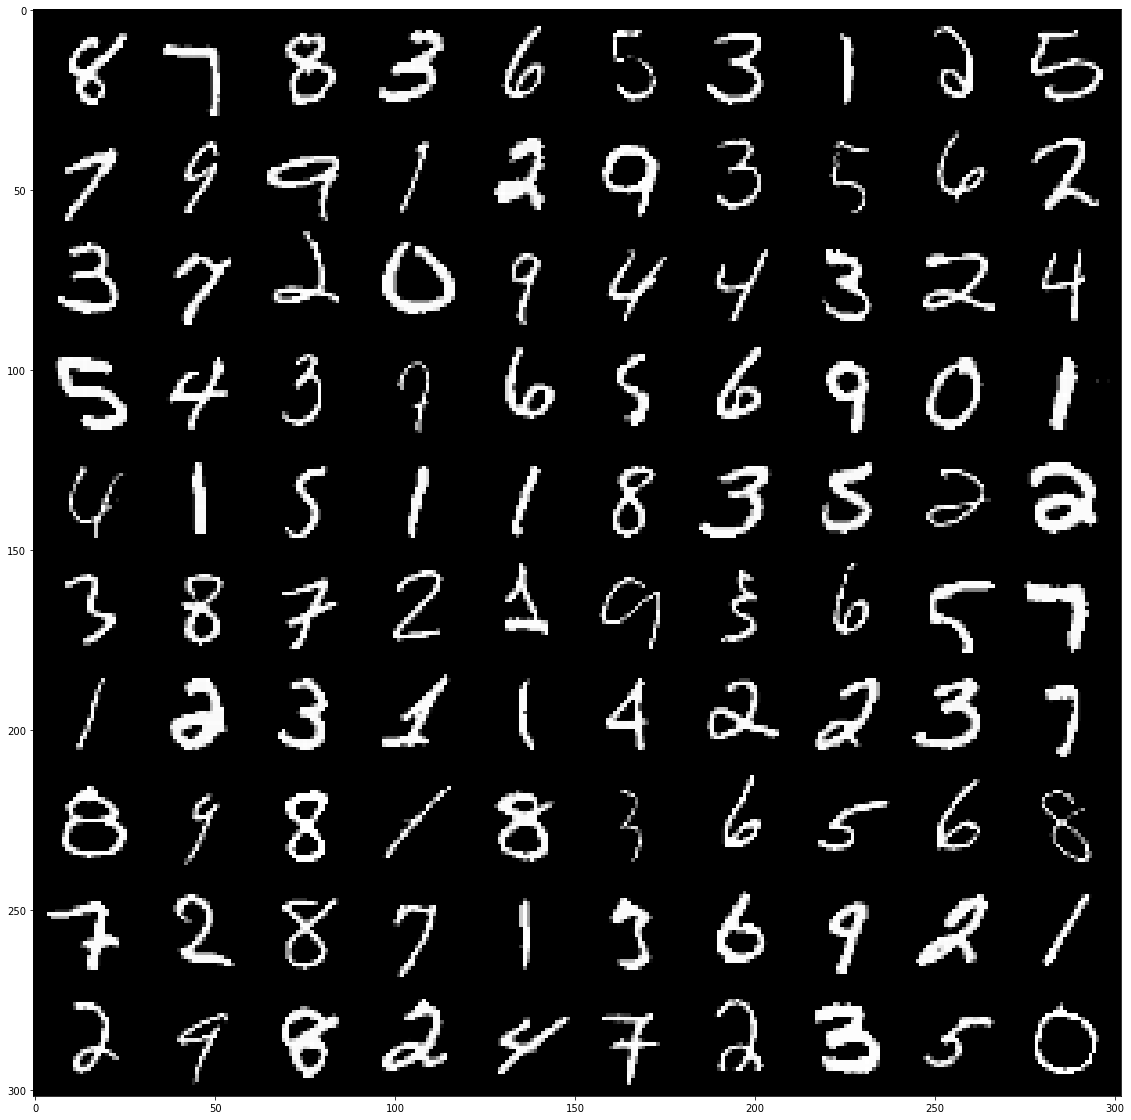

In [19]:
g_truth = torchvision.utils.make_grid(dat[0][:100], nrow=10)
plt.figure(figsize=(20, 20))
plt.imshow(g_truth.permute(1,2,0))